Import Library

In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

import torchvision
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import warnings
warnings.filterwarnings('ignore')
import os

#추가한것
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
#

from efficientnet_pytorch import EfficientNet

#CUDA활성화 
device = torch.device('cuda' if torch.cuda.is_available() else "cuda not available. Training on CPU")
#check if CUDA is available
print({'cuda availability':device})

# remove any GPU memory 
import gc
gc.collect()

print('...emptying GPU memory')
torch.cuda.empty_cache()

{'cuda availability': device(type='cuda')}
...emptying GPU memory


Define model class

In [ ]:
class PretrainModel(nn.Module):
    def __init__(self,pretrained):
        super().__init__()
        self.conv2d = nn.Conv2d(3, 3, 3, stride=1)
        self.pretrained = pretrained
        self.FC = nn.Linear(1000,4)
    
    def forward(self,x):
        x = self.conv2d(x)
        x = self.pretrained(x)
        x = self.FC(x)
        return x


pretrained = EfficientNet.from_pretrained('efficientnet-b1') # pretrained model 설정
model = PretrainModel(pretrained)
model.to(device)

Data path, transform and DataLoader

In [3]:
img_path = r'D:\AI_PFT_data_for_modeling_20220207_2000' + '//'

'''transform'''
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = T.Compose([#tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         #tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         T.Resize((304, 304)),
                         T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         T.ToTensor(), 
                         T.Normalize(*stats,inplace=True)])
valid_tfms = T.Compose([T.Resize((304, 304)),T.ToTensor(), T.Normalize(*stats)])
test_tfms = T.Compose([T.Resize((304, 304)),T.ToTensor(), T.Normalize(*stats)])



'''Define dataset'''
train_ds = ImageFolder(img_path + '/train', train_tfms)
valid_ds = ImageFolder(img_path + '/val', valid_tfms)
test_ds = ImageFolder(img_path + '/test', test_tfms)


print(train_ds, valid_ds, test_ds)


'''Define dataloader'''
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)


helper functions, loss function, optimizer

In [5]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
    
# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b



# function to calculate loss and metric per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

Train Function

In [6]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_loader=params["train_loader"]
    valid_loader=params["valid_loader"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_loader, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, valid_loader, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            # torch.save(model.state_dict(), path2weights)
            # print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [7]:
# definc the training parameters
params_train = {
    'num_epochs':num_epochs,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_loader':train_loader,
    'valid_loader':valid_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

Actual Training 

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Plot

In [ ]:
'''check train loss, val loss, accuracy table'''
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

evaluate from test

In [ ]:
import seaborn as sns
import pandas as pd
label2class = {'Asthma': 'Asthma', 'COPD': 'COPD', 'IPF': 'IPF' , 'Normal': 'Normal' }

nb_classes = 4
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=25)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=25)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

evaulate from test_alternative 

              precision    recall  f1-score   support

      Asthma       0.63      0.59      0.61       600
        COPD       0.78      0.80      0.79       600
         IPF       0.79      0.81      0.80       600
      Normal       0.74      0.74      0.74       600

    accuracy                           0.74      2400
   macro avg       0.73      0.74      0.74      2400
weighted avg       0.73      0.74      0.74      2400



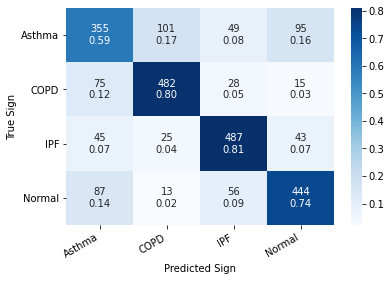

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

'''confusion matrix''' 
def show_confusion_matrix(confusion_matrix, class_names):
    cm = confusion_matrix.copy()
    cell_counts = cm.flatten()
    cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
    cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
    hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Sign')
    plt.xlabel('Predicted Sign')
    plt.show()
    
lst_result_total=[]    
y_pred, y_test = get_predictions(model, test_loader)
lst_result_total.append([y_pred,y_test])

# 각종 지표 결과
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)